In [1]:
import pickle
import numpy as np
import os
import torch
import json
import shlex
import pickle
import time
import subprocess
import numpy as np
import torch.utils.data as data
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import datasets.data_utils as d_utils
import pandas as pd

from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from utils.util import AverageMeter, shapenetpart_metrics
from models.backbones import ResNet
from models.heads import ClassifierResNet, MultiPartSegHeadResNet, SceneSegHeadResNet
from models.losses import LabelSmoothingCrossEntropyLoss, MultiShapeCrossEntropy, MaskedCrossEntropy
from utils.config import config, update_config
from utils.lr_scheduler import get_scheduler
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
from IPython.display import clear_output
import pickle

def config_seting(cfg = 'cfgs/brain/brain.yaml'):
    update_config(cfg)
    return config


# Usefull functional for dataprocesing, train and validation

In [2]:

class BrainDataSeg():
    def __init__(self, data_type = 'train', num_points = 2048, 
                 transforms=None,
                 data_post = '',
                 datafolder = 'BrainData'):
        self.num_points = num_points
        self.transforms = transforms
        if data_type == 'test':
            filename = f'data/{datafolder}/test_data{data_post}.pkl'
        if data_type == 'train':
            filename = f'data/{datafolder}/trainval_data{data_post}.pkl'
        with open(filename, 'rb') as f:
            self.points, self.points_labels, self.labels = pickle.load(f)
        print(f"{filename} loaded successfully")

    def __getitem__(self, idx):
        current_points = self.points[idx]
        current_points_labels = self.points_labels[idx]
        cur_num_points = current_points.shape[0]
        if cur_num_points >= self.num_points:
            choice = np.random.choice(cur_num_points, self.num_points)
            current_points = current_points[choice, :]
            current_points_labels = current_points_labels[choice]
            mask = torch.ones(self.num_points).type(torch.int32)
        else:
            padding_num = self.num_points - cur_num_points
            shuffle_choice = np.random.permutation(np.arange(cur_num_points))
            padding_choice = np.random.choice(cur_num_points, padding_num)
            choice = np.hstack([shuffle_choice, padding_choice])
            current_points = current_points[choice, :]
            current_points_labels = current_points_labels[choice]
            mask = torch.cat([torch.ones(cur_num_points), torch.zeros(padding_num)]).type(torch.int32)
        if self.transforms is not None:
            current_points = self.transforms(current_points)
        label = torch.from_numpy(self.labels[idx]).type(torch.int64)
        current_points_labels = torch.from_numpy(current_points_labels).type(torch.int64)

        return current_points, mask, current_points_labels, label

    def __len__(self):
        return len(self.points)
def get_loader(num_points,batch_size = 16,data_post = '', datafolder = 'BrainData'):
    trans = transforms.Compose([d_utils.PointcloudToTensor()])
    train_dataset = BrainDataSeg(num_points=num_points,
                                 data_type = 'train',
                                 transforms = trans, 
                                 data_post = data_post,
                                 datafolder = datafolder
                                )
    test_dataset = BrainDataSeg(num_points=num_points,
                                data_type = 'test',
                                transforms = trans, 
                                data_post = data_post,
                               datafolder = datafolder)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               pin_memory=True,
                                               drop_last=True)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              pin_memory=True,
                                              drop_last=False)

    return train_loader, test_loader
class MultiPartSegmentationModel(nn.Module):
    def __init__(self, config, backbone, head, num_classes, num_parts,
                 input_features_dim, radius, sampleDl, nsamples, npoints,
                 width=144, depth=2, bottleneck_ratio=2):
        super(MultiPartSegmentationModel, self).__init__()
        if backbone == 'resnet':
            self.backbone = ResNet(config, input_features_dim, radius, sampleDl, nsamples, npoints,
                                   width=width, depth=depth, bottleneck_ratio=bottleneck_ratio)
        else:
            raise NotImplementedError(f"Backbone {backbone} not implemented in Multi-Part Segmentation Model")

        if head == 'resnet_part_seg':
            self.segmentation_head = MultiPartSegHeadResNet(num_classes, width, radius, nsamples, num_parts)
        else:
            raise NotImplementedError(f"Head {backbone} not implemented in Multi-Part Segmentation Model")

    def forward(self, xyz, mask, features):
        end_points = self.backbone(xyz, mask, features)
        return self.segmentation_head(end_points)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
def build_multi_part_segmentation(config, weights = None):
    model = MultiPartSegmentationModel(config, config.backbone, config.head, config.num_classes, config.num_parts,
                                       config.input_features_dim,
                                       config.radius, config.sampleDl, config.nsamples, config.npoints,
                                       config.width, config.depth, config.bottleneck_ratio)
    criterion = MultiShapeCrossEntropy(config.num_classes, weights)
    return model, criterion
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

def train(epoch, train_loader, model, criterion, optimizer, scheduler, config):
    """ One epoch training
    """
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    loss_meter = AverageMeter()
    end = time.time()
    pred_soft_flats = []
    points_labels_flats = []
    for idx, (points, mask, points_labels, shape_labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        bsz = points.size(0)
        # forward
        features = points
        features = features.transpose(1, 2).contiguous()

        points = points[:,:,:3].cuda(non_blocking=True)
        mask = mask.cuda(non_blocking=True)
        features = features.cuda(non_blocking=True)
        points_labels = points_labels.cuda(non_blocking=True)
        shape_labels = shape_labels.cuda(non_blocking=True)
        pred = model(points, mask, features)
        loss = criterion(pred, points_labels, shape_labels)
        
        m = torch.nn.Softmax(dim=1)
        pred_soft_flats += list(np.array(m(pred[0])[:,1,:].reshape(-1).detach().cpu()))
        points_labels_flats += list(np.array(points_labels.reshape(-1).detach().cpu()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # update meters
        loss_meter.update(loss.item(), bsz)
        batch_time.update(time.time() - end)
        end = time.time()

    print('roc train',roc_auc_score(points_labels_flats,pred_soft_flats))
    opt = Find_Optimal_Cutoff(points_labels_flats, pred_soft_flats)
    print('optimal cut',opt)

    return loss_meter.avg, opt

def validate(epoch, test_loader, model, criterion, config, num_votes=10, is_conf = False):
    """ One epoch validating
    """
    batch_time = AverageMeter()
    losses = AverageMeter()

    model.eval()
    with torch.no_grad():
        all_logits = []
        all_points_labels = []
        all_shape_labels = []
        all_masks = []
        end = time.time()
        TS = d_utils.BatchPointcloudScaleAndJitter(scale_low=config.scale_low,
                                                   scale_high=config.scale_high,
                                                   std=config.noise_std,
                                                   clip=config.noise_clip)
        pred_soft_flats = []
        points_labels_flats = []
        for idx, (points_orig, mask, points_labels, shape_labels) in enumerate(test_loader):
            vote_logits = None
            vote_points_labels = None
            vote_shape_labels = None
            vote_masks = None
            for v in range(num_votes):
                batch_logits = []
                batch_points_labels = []
                batch_shape_labels = []
                batch_masks = []
                # augment for voting
                if v > 0:
                    points = TS(points_orig)
                else:
                    points = points_orig
                # forward
                features = points
                features = features.transpose(1, 2).contiguous()
                points = points[:,:,:3].cuda(non_blocking=True)
                mask = mask.cuda(non_blocking=True)
                features = features.cuda(non_blocking=True)
                points_labels = points_labels.cuda(non_blocking=True)
                shape_labels = shape_labels.cuda(non_blocking=True)

                pred = model(points, mask, features)
                loss = criterion(pred, points_labels, shape_labels)
                losses.update(loss.item(), points.size(0))
                
                m = torch.nn.Softmax(dim=1)
                pred_soft_flats += list(np.array(m(pred[0])[:,1,:].reshape(-1).detach().cpu()))
                points_labels_flats += list(np.array(points_labels.reshape(-1).detach().cpu()))
                

                # collect
                bsz = points.shape[0]
                for ib in range(bsz):
                    sl = shape_labels[ib]
                    logits = pred[sl][ib]
                    pl = points_labels[ib]
                    pmk = mask[ib]
                    batch_logits.append(logits.cpu().numpy())
                    batch_points_labels.append(pl.cpu().numpy())
                    batch_shape_labels.append(sl.cpu().numpy())
                    batch_masks.append(pmk.cpu().numpy().astype(np.bool))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                if vote_logits is None:
                    vote_logits = batch_logits
                    vote_points_labels = batch_points_labels
                    vote_shape_labels = batch_shape_labels
                    vote_masks = batch_masks
                else:
                    for i in range(len(vote_logits)):
                        vote_logits[i] = vote_logits[i] + (batch_logits[i] - vote_logits[i]) / (v + 1)

            all_logits += vote_logits
            all_points_labels += vote_points_labels
            all_shape_labels += vote_shape_labels
            all_masks += vote_masks
            if idx % config.print_freq == 0:
                print(
                    f'V{num_votes} Test: [{idx}/{len(test_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {losses.val:.4f} ({losses.avg:.4f})')
                

        print('roc test',roc_auc_score(points_labels_flats,pred_soft_flats))
            
        if is_conf:
            acc, shape_ious, msIoU, mIoU, confs = shapenetpart_metrics(config.num_classes,
                                                            config.num_parts,
                                                            all_shape_labels,
                                                            all_logits,
                                                            all_points_labels,
                                                            all_masks, is_conf = is_conf)
        else:
            acc, shape_ious, msIoU, mIoU = shapenetpart_metrics(config.num_classes,
                                                            config.num_parts,
                                                            all_shape_labels,
                                                            all_logits,
                                                            all_points_labels,
                                                            all_masks, is_conf = is_conf)
            
    if is_conf:
        return losses.avg,acc, msIoU, mIoU, confs
    else:
        return losses.avg,acc, msIoU, mIoU

# Hyperparameters

In [3]:
WEIGHTS = [1,40]
DATA_POSTFIX = '_2exp'
CFG = 'cfgs/brain/brain2exp.yaml'
IS_CONF = True
DATAFOLDER = 'BrainData'

# Data processing, train and validation

In [4]:
config = config_seting(CFG)

/home/guest/CloserLook3D/pytorch/utils/config.py:108: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [5]:
train_loader, test_loader = get_loader(num_points = config.num_points, 
                                       data_post = DATA_POSTFIX, 
                                       datafolder = DATAFOLDER )

data/BrainData/trainval_data_2exp.pkl loaded successfully
data/BrainData/test_data_2exp.pkl loaded successfully


In [6]:
n_data = len(train_loader.dataset)
print(f"length of training dataset: {n_data}")
n_data = len(test_loader.dataset)
print(f"length of testing dataset: {n_data}")

length of training dataset: 1225
length of testing dataset: 100


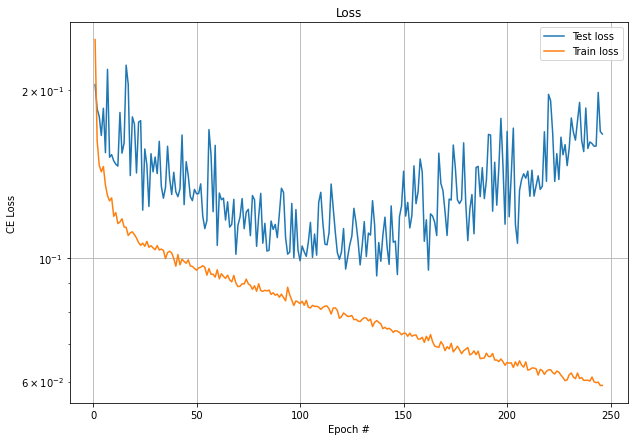

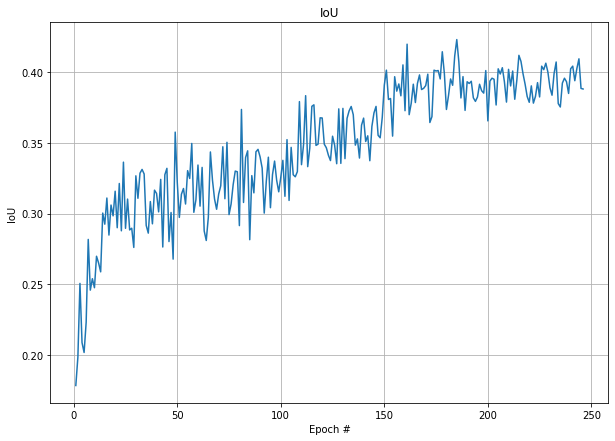

roc train 0.9962472749511906


KeyboardInterrupt: 

In [7]:
model, criterion = build_multi_part_segmentation(config, WEIGHTS)
# print(str(model))
model.cuda()
criterion.cuda()
if config.optimizer == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(),
                                    lr=config.batch_size * dist.get_world_size() / 16 * config.base_learning_rate,
                                    momentum=config.momentum,
                                    weight_decay=config.weight_decay)
elif config.optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config.base_learning_rate,
                                 weight_decay=config.weight_decay)
elif config.optimizer == 'adamW':
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=config.base_learning_rate,
                                  weight_decay=config.weight_decay)
else:
    raise NotImplementedError(f"Optimizer {config.optimizer} not supported")

scheduler = get_scheduler(optimizer, len(train_loader), config)
train_losses = []
test_iou = []
test_losses = []

for epoch in range(config.start_epoch, config.epochs + 1):

    tic = time.time()
    loss, opt = train(epoch, train_loader, model, criterion, optimizer, scheduler, config)

    print('epoch {}, total time {:.2f}, lr {:.5f}'.format(epoch,
                                                                (time.time() - tic),
                                                                optimizer.param_groups[0]['lr']))
    tmp = validate(epoch, test_loader, model, criterion, config, num_votes=1, is_conf = IS_CONF)
    if IS_CONF:
        loss_test,acc, msIoU, mIoU,confs = tmp
    else:
        loss_test,acc, msIoU, mIoU = tmp
    
    
    print('test_loss', loss_test)
    print('ins_loss', loss)
    print('test_acc', acc)
    print('msIoU', msIoU)
    print('mIoU', mIoU)
    if IS_CONF:
        print(confs)
    test_losses.append(loss_test)
    train_losses.append(loss)
    test_iou.append(msIoU)
    
    res_dict = {'test_loss':test_losses,'train_loss':train_losses,'iou':test_iou}
    with open('2_exp_output.pkl', 'wb') as handle:
        pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('2_exp_output.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
    
    clear_output(wait=True)
    plt.figure(figsize = (10,7))
    plt.semilogy(range(1, len(res_dict['iou'])+1),res_dict['test_loss'], label = 'Test loss')
    plt.semilogy(range(1, len(res_dict['iou'])+1),res_dict['train_loss'], label = 'Train loss')
    plt.ylabel('CE Loss')
    plt.xlabel('Epoch #')
    plt.legend()
    plt.grid()
    plt.title('Loss')
    plt.show()
    
    plt.figure(figsize = (10,7))
    plt.plot(range(1, len(res_dict['iou'])+1),res_dict['iou'])
    plt.grid()
    plt.title('IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch #')
    plt.show()
    
    if epoch > 1:
        if res_dict['test_loss'][-1] < np.min(res_dict['test_loss'][:-1]):
            torch.save(model.state_dict(), '2_exp_model.pkl')

